In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from scipy.stats import poisson
import numpy as np
import scipy.stats as stats
import re

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
os.chdir('..')
os.getcwd()

'/Users/benmurphy/Projects/rugby/rugby'

In [3]:
raw_df = pd.read_csv("0_data/match_data/urc_matches.csv")
raw_df

,match_date_dt,match_date_time_dt,season,home_team,away_team,home_score,away_score,home_n_tries,home_n_conversions,home_n_pen_kicks,...,away_n_pen_kicks,away_n_pen_tries,home_forwards_average_age,home_backs_average_age,home_tallest_player,home_pack_weight_kg,away_forwards_average_age,away_backs_average_age,away_tallest_player,away_pack_weight_kg
0,2021-09-24,2021-09-24 18:35:00,21/22,ZEBRE,LIONS,26,38,4.0,2.0,0.0,...,1.0,0.0,26,26,198,924,27,25,199,919
1,2021-09-24,2021-09-24 20:35:00,21/22,CARDIFF,CONNACHT,33,21,5.0,4.0,0.0,...,3.0,0.0,28,27,203,929,26,26,198,892
2,2021-09-24,2021-09-24 20:35:00,21/22,ULSTER,GLASGOW,35,29,5.0,4.0,0.0,...,1.0,1.0,29,26,201,906,28,26,205,912
3,2021-09-25,2021-09-25 14:00:00,21/22,BENETTON,STORMERS,22,18,3.0,2.0,1.0,...,2.0,0.0,24,26,200,909,27,25,200,903
4,2021-09-25,2021-09-25 18:15:00,21/22,LEINSTER,BULLS,31,3,4.0,4.0,1.0,...,1.0,0.0,26,27,201,920,27,26,203,934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2025-05-17,2025-05-17 15:00:00,24/25,BULLS,DRAGONS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
593,2025-05-17,2025-05-17 17:15:00,24/25,LIONS,OSPREYS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
594,2025-05-17,2025-05-17 18:00:00,24/25,ZEBRE,CONNACHT,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
595,2025-05-17,2025-05-17 19:30:00,24/25,SHARKS,SCARLETS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [4]:
raw_df = raw_df.loc[raw_df['match_date_dt'] < "2024-12-04"]

raw_df.loc[raw_df['match_date_dt'] == "2024-11-30", "home_score"] = np.nan
raw_df.loc[raw_df['match_date_dt'] == "2024-11-30", "away_score"] = np.nan

raw_df.tail(8)

,match_date_dt,match_date_time_dt,season,home_team,away_team,home_score,away_score,home_n_tries,home_n_conversions,home_n_pen_kicks,...,away_n_pen_kicks,away_n_pen_tries,home_forwards_average_age,home_backs_average_age,home_tallest_player,home_pack_weight_kg,away_forwards_average_age,away_backs_average_age,away_tallest_player,away_pack_weight_kg
499,2024-11-29,2024-11-29 20:35:00,24/25,GLASGOW,SCARLETS,17.0,15.0,2.0,2.0,1.0,...,1.0,0.0,26,27,207,915,29,25,201,909
500,2024-11-29,2024-11-29 20:35:00,24/25,ULSTER,LEINSTER,20.0,27.0,2.0,2.0,2.0,...,1.0,0.0,26,26,199,899,27,25,200,900
501,2024-11-30,2024-11-30 16:00:00,24/25,SHARKS,STORMERS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29,26,203,909,30,27,203,924
502,2024-11-30,2024-11-30 18:15:00,24/25,CARDIFF,DRAGONS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28,27,201,911,27,26,198,907
503,2024-11-30,2024-11-30 18:30:00,24/25,CONNACHT,BULLS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29,26,201,901,27,27,201,943
504,2024-11-30,2024-11-30 20:35:00,24/25,EDINBURGH,BENETTON,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28,26,200,931,28,27,201,916
505,2024-11-30,2024-11-30 20:35:00,24/25,ZEBRE,OSPREYS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25,26,202,890,27,25,204,868
506,2024-11-30,2024-11-30 20:35:00,24/25,MUNSTER,LIONS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,27,27,201,887,26,26,200,924


In [5]:
raw_df.columns

Index(['match_date_dt', 'match_date_time_dt', 'season', 'home_team',
       'away_team', 'home_score', 'away_score', 'home_n_tries',
       'home_n_conversions', 'home_n_pen_kicks', 'home_n_pen_tries',
       'away_n_tries', 'away_n_conversions', 'away_n_pen_kicks',
       'away_n_pen_tries', 'home_forwards_average_age',
       'home_backs_average_age', 'home_tallest_player', 'home_pack_weight_kg',
       'away_forwards_average_age', 'away_backs_average_age',
       'away_tallest_player', 'away_pack_weight_kg'],
      dtype='object')

In [6]:
def match_outcome(h,a):
    if h > a:
        return 1
    elif h < a:
        return -1
    else:
        return 0
        
raw_df['outcome'] = raw_df.apply(lambda x: match_outcome(x.home_score, x.away_score), axis=1)


raw_df[['match_date_dt', 'home_team', 'away_team', 
    'home_score', 'away_score', 'outcome']]

/var/folders/xr/_sn2jn9s3xd13fp9ljzys7tm0000gn/T/ipykernel_11022/375106086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['outcome'] = raw_df.apply(lambda x: match_outcome(x.home_score, x.away_score), axis=1)


,match_date_dt,home_team,away_team,home_score,away_score,outcome
0,2021-09-24,ZEBRE,LIONS,26.0,38.0,-1
1,2021-09-24,CARDIFF,CONNACHT,33.0,21.0,1
2,2021-09-24,ULSTER,GLASGOW,35.0,29.0,1
3,2021-09-25,BENETTON,STORMERS,22.0,18.0,1
4,2021-09-25,LEINSTER,BULLS,31.0,3.0,1
...,...,...,...,...,...,...
502,2024-11-30,CARDIFF,DRAGONS,NaN,NaN,0
503,2024-11-30,CONNACHT,BULLS,NaN,NaN,0
504,2024-11-30,EDINBURGH,BENETTON,NaN,NaN,0
505,2024-11-30,ZEBRE,OSPREYS,NaN,NaN,0


In [7]:
raw_df['outcome'].value_counts()

outcome
 1    322
-1    169
 0     16
Name: count, dtype: int64

In [8]:
features = ['match_date_dt', 'home_team', 'away_team', 'season',
            'home_score', 'away_score', 'outcome',
            
            'home_n_tries', 'away_n_tries', 
            'home_n_conversions', 'away_n_conversions',
            'home_n_pen_kicks', 'away_n_pen_kicks',
            'home_n_pen_tries', 'away_n_pen_tries', 

            
            'home_forwards_average_age', 'home_backs_average_age',
            'away_forwards_average_age', 'away_backs_average_age',
            'home_tallest_player', 'home_pack_weight_kg',
            'away_tallest_player', 'away_pack_weight_kg'
           ]

# home data
home_data = raw_df[features].copy()

home_data['team_location'] = "Home"
home_data.rename(columns={"home_team": "team",
                    "away_team": "opponents",
                    "home_score": "team_score",
                    "away_score": "opponent_score",

                    "home_n_tries": "tries_scored",
                    "away_n_tries": "tries_conceded",
                    "home_n_conversions": "conversions_scored",
                    "away_n_conversions": "conversions_conceded",
                    "home_n_pen_kicks": "pen_kicks_scored",
                    "away_n_pen_kicks": "pen_kicks_conceded",
                    "home_n_pen_tries": "pen_tries_scored",
                    "away_n_pen_tries": "pen_tries_conceded",
                    
                    "home_forwards_average_age": "team_forwards_average_age",
                    "home_backs_average_age": "team_backs_average_age",
                    "away_forwards_average_age": "opposition_forwards_average_age",
                    "away_backs_average_age": "opposition_backs_average_age",

                    "home_tallest_player": "team_tallest_player",
                    "away_tallest_player": "opposition_tallest_player",

                    "home_pack_weight_kg": "team_pack_weight_kg",
                    "away_pack_weight_kg": "opposition_pack_weight_kg"
                    },
                    inplace=True)

# away data
away_data = raw_df[features].copy()
away_data['team_location'] = "Away"
away_data.rename(columns={"away_team": "team",
                    "home_team": "opponents",
                    "away_score": "team_score",
                    "home_score": "opponent_score",
                    "away_n_tries": "tries_scored",
                    "home_n_tries": "tries_conceded",
                    "away_n_conversions": "conversions_scored",
                    "home_n_conversions": "conversions_conceded",
                    "away_n_pen_kicks": "pen_kicks_scored",
                    "home_n_pen_kicks": "pen_kicks_conceded",
                    "away_n_pen_tries": "pen_tries_scored",
                    "home_n_pen_tries": "pen_tries_conceded",

                    "away_forwards_average_age": "team_forwards_average_age",
                    "away_backs_average_age": "team_backs_average_age",
                    "home_forwards_average_age": "opposition_forwards_average_age",
                    "home_backs_average_age": "opposition_backs_average_age",

                    "away_tallest_player": "team_tallest_player",
                    "home_tallest_player": "opposition_tallest_player",

                    "away_pack_weight_kg": "team_pack_weight_kg",
                    "home_pack_weight_kg": "opposition_pack_weight_kg"

                    },
                    inplace=True)

# concat dfs together
df = pd.concat([home_data, away_data])

df = df.sort_values(by='match_date_dt').reset_index(drop=False, names='match_per_row_index')

df['tries_scored'] = df['tries_scored'] - df['pen_tries_scored']

df

,match_per_row_index,match_date_dt,team,opponents,season,team_score,opponent_score,outcome,tries_scored,tries_conceded,...,pen_tries_conceded,team_forwards_average_age,team_backs_average_age,opposition_forwards_average_age,opposition_backs_average_age,team_tallest_player,team_pack_weight_kg,opposition_tallest_player,opposition_pack_weight_kg,team_location
0,0,2021-09-24,ZEBRE,LIONS,21/22,26.0,38.0,-1,3.0,5.0,...,0.0,26,26,27,25,198,924,199,919,Home
1,1,2021-09-24,CONNACHT,CARDIFF,21/22,21.0,33.0,1,2.0,5.0,...,0.0,26,26,28,27,198,892,203,929,Away
2,0,2021-09-24,LIONS,ZEBRE,21/22,38.0,26.0,-1,5.0,4.0,...,1.0,27,25,26,26,199,919,198,924,Away
3,2,2021-09-24,GLASGOW,ULSTER,21/22,29.0,35.0,1,3.0,5.0,...,1.0,28,26,29,26,205,912,201,906,Away
4,1,2021-09-24,CARDIFF,CONNACHT,21/22,33.0,21.0,1,5.0,2.0,...,0.0,28,27,26,26,203,929,198,892,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,2024-11-30,CONNACHT,BULLS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,29,26,27,27,201,901,201,943,Home
1010,502,2024-11-30,CARDIFF,DRAGONS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,28,27,27,26,201,911,198,907,Home
1011,501,2024-11-30,SHARKS,STORMERS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,29,26,30,27,203,909,203,924,Home
1012,505,2024-11-30,OSPREYS,ZEBRE,24/25,NaN,NaN,0,NaN,NaN,...,NaN,27,25,25,26,204,868,202,890,Away


In [9]:
df.dtypes

match_per_row_index                  int64
match_date_dt                       object
team                                object
opponents                           object
season                              object
team_score                         float64
opponent_score                     float64
outcome                              int64
tries_scored                       float64
tries_conceded                     float64
conversions_scored                 float64
conversions_conceded               float64
pen_kicks_scored                   float64
pen_kicks_conceded                 float64
pen_tries_scored                   float64
pen_tries_conceded                 float64
team_forwards_average_age            int64
team_backs_average_age               int64
opposition_forwards_average_age      int64
opposition_backs_average_age         int64
team_tallest_player                  int64
team_pack_weight_kg                  int64
opposition_tallest_player            int64
opposition_

# What window size to use for tries

Window size: 3 - Corr: 0.146
Window size: 4 - Corr: 0.132
Window size: 5 - Corr: 0.146
Window size: 6 - Corr: 0.154
Window size: 7 - Corr: 0.152
Window size: 8 - Corr: 0.161
Window size: 9 - Corr: 0.152
Window size: 10 - Corr: 0.166
Window size: 11 - Corr: 0.167
Window size: 12 - Corr: 0.175
Window size: 13 - Corr: 0.18
Window size: 14 - Corr: 0.178
Window size: 15 - Corr: 0.165
Window size: 16 - Corr: 0.19
Window size: 17 - Corr: 0.205
Window size: 18 - Corr: 0.214
Window size: 19 - Corr: 0.215
Window size: 20 - Corr: 0.221
Window size: 21 - Corr: 0.219
Window size: 22 - Corr: 0.218
Window size: 23 - Corr: 0.221
Window size: 24 - Corr: 0.219
Window size: 25 - Corr: 0.23
Window size: 26 - Corr: 0.233
Window size: 27 - Corr: 0.235
Window size: 28 - Corr: 0.236
Window size: 29 - Corr: 0.227


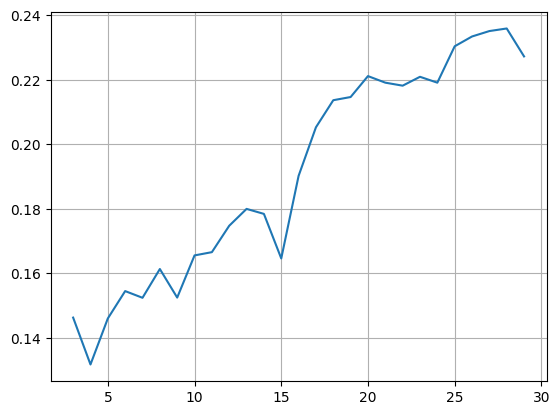

In [10]:
corrs = []
window_sizes = np.arange(3, 30, 1)

for w in window_sizes:
    last_n_avgs = df.groupby('team')[['tries_scored']] \
                .rolling(w, closed='left') \
                .mean() \
                .reset_index().rename(columns={"level_1":"row_index",
                                            "tries_scored": f"tries_scored_last_{w}"})
    last_n_avgs.index = last_n_avgs['row_index']
    last_n_avgs = last_n_avgs.sort_index()

    temp = pd.concat([df[['tries_scored']], last_n_avgs[[f"tries_scored_last_{w}"]]], 
                      axis=1).dropna()
    
    corr_ = temp.corr().iloc[0].iloc[1]
    corrs.append(corr_)
    print(f"Window size: {w} - Corr: {round(corr_, 3)}")


plt.plot(window_sizes, corrs)
plt.grid(True)
plt.show()

In [11]:
last_8_avgs = df.groupby('team')[['tries_scored', 
                                  'conversions_scored', 
                                  'pen_kicks_scored']
                                ].rolling(8, closed='left').mean().reset_index().rename(columns={"level_1":"row_index",
                                                                                                "tries_scored": "tries_scored_last_8",
                                                                                                "conversions_scored": "conversions_scored_last_8",
                                                                                                "pen_kicks_scored": "pen_kicks_scored_last_8"})

last_8_avgs.index = last_8_avgs['row_index']

last_8_avgs.sort_index()

,team,row_index,tries_scored_last_8,conversions_scored_last_8,pen_kicks_scored_last_8
row_index,,,,,
0,ZEBRE,0,NaN,NaN,NaN
1,CONNACHT,1,NaN,NaN,NaN
2,LIONS,2,NaN,NaN,NaN
3,GLASGOW,3,NaN,NaN,NaN
4,CARDIFF,4,NaN,NaN,NaN
...,...,...,...,...,...
1009,CONNACHT,1009,3.375,2.375,0.375
1010,CARDIFF,1010,3.500,2.250,0.500
1011,SHARKS,1011,3.125,2.625,1.125


In [12]:
def get_window_average(df, feature, window_size):

    temp = df.copy()
    feature_name = f"{feature}_last_{window_size}"
    last_n_avg = temp.groupby('team')[[feature]].rolling(window_size, closed='left').mean().reset_index().rename(columns={"level_1":"row_index",
                                                                                                            f"{feature}": feature_name})
    last_n_avg.index = last_n_avg['row_index']
    last_n_avg = last_n_avg.sort_index()

    return last_n_avg[[feature_name]]

In [13]:
tries_scored_last_18 = get_window_average(df, 'tries_scored', 18).sort_index()
tries_scored_last_13 = get_window_average(df, 'tries_scored', 13).sort_index()
tries_scored_last_8 = get_window_average(df, 'tries_scored', 8).sort_index()

tries_scored_last_18.tail()

,tries_scored_last_18
row_index,
1009,3.166667
1010,2.944444
1011,3.055556
1012,2.611111
1013,3.888889


In [14]:
df.head(10)

,match_per_row_index,match_date_dt,team,opponents,season,team_score,opponent_score,outcome,tries_scored,tries_conceded,...,pen_tries_conceded,team_forwards_average_age,team_backs_average_age,opposition_forwards_average_age,opposition_backs_average_age,team_tallest_player,team_pack_weight_kg,opposition_tallest_player,opposition_pack_weight_kg,team_location
0,0,2021-09-24,ZEBRE,LIONS,21/22,26.0,38.0,-1,3.0,5.0,...,0.0,26,26,27,25,198,924,199,919,Home
1,1,2021-09-24,CONNACHT,CARDIFF,21/22,21.0,33.0,1,2.0,5.0,...,0.0,26,26,28,27,198,892,203,929,Away
2,0,2021-09-24,LIONS,ZEBRE,21/22,38.0,26.0,-1,5.0,4.0,...,1.0,27,25,26,26,199,919,198,924,Away
3,2,2021-09-24,GLASGOW,ULSTER,21/22,29.0,35.0,1,3.0,5.0,...,1.0,28,26,29,26,205,912,201,906,Away
4,1,2021-09-24,CARDIFF,CONNACHT,21/22,33.0,21.0,1,5.0,2.0,...,0.0,28,27,26,26,203,929,198,892,Home
5,2,2021-09-24,ULSTER,GLASGOW,21/22,35.0,29.0,1,4.0,4.0,...,1.0,29,26,28,26,201,906,205,912,Home
6,4,2021-09-25,BULLS,LEINSTER,21/22,3.0,31.0,1,0.0,4.0,...,0.0,27,26,26,27,203,934,201,920,Away
7,5,2021-09-25,SCARLETS,EDINBURGH,21/22,22.0,26.0,1,3.0,4.0,...,0.0,29,27,28,26,203,906,200,950,Away
8,6,2021-09-25,SHARKS,MUNSTER,21/22,17.0,42.0,1,2.0,6.0,...,0.0,26,24,28,25,201,946,203,907,Away
9,3,2021-09-25,BENETTON,STORMERS,21/22,22.0,18.0,1,3.0,2.0,...,0.0,24,26,27,25,200,909,200,903,Home


# What window size to use for penalties

Window size: 3 - Corr: 0.097
Window size: 4 - Corr: 0.096
Window size: 5 - Corr: 0.119
Window size: 6 - Corr: 0.118
Window size: 7 - Corr: 0.115
Window size: 8 - Corr: 0.141
Window size: 9 - Corr: 0.139
Window size: 10 - Corr: 0.148
Window size: 11 - Corr: 0.147
Window size: 12 - Corr: 0.143
Window size: 13 - Corr: 0.154
Window size: 14 - Corr: 0.142
Window size: 15 - Corr: 0.148
Window size: 16 - Corr: 0.166
Window size: 17 - Corr: 0.169
Window size: 18 - Corr: 0.183
Window size: 19 - Corr: 0.175
Window size: 20 - Corr: 0.169
Window size: 21 - Corr: 0.172
Window size: 22 - Corr: 0.171
Window size: 23 - Corr: 0.174
Window size: 24 - Corr: 0.156
Window size: 25 - Corr: 0.161
Window size: 26 - Corr: 0.16
Window size: 27 - Corr: 0.162
Window size: 28 - Corr: 0.163
Window size: 29 - Corr: 0.178


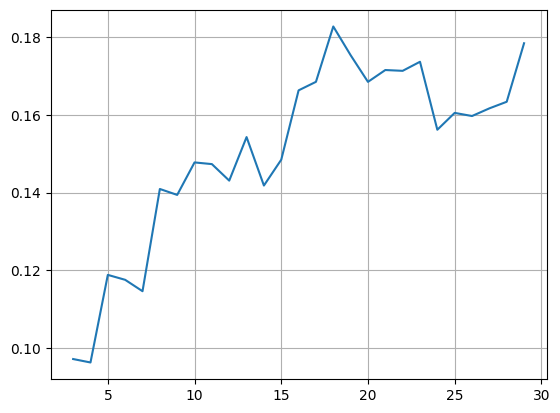

In [15]:
corrs = []
window_sizes = np.arange(3, 30, 1)

for w in window_sizes:
    last_n_avgs = df.groupby('team')[['pen_kicks_scored']] \
                .rolling(w, closed='left') \
                .mean() \
                .reset_index().rename(columns={"level_1":"row_index",
                                            "pen_kicks_scored": f"pen_kicks_scored_last_{w}"})
    last_n_avgs.index = last_n_avgs['row_index']
    last_n_avgs = last_n_avgs.sort_index()

    temp = pd.concat([df[['pen_kicks_scored']], last_n_avgs[[f"pen_kicks_scored_last_{w}"]]], 
                      axis=1).dropna()
    
    corr_ = temp.corr().iloc[0].iloc[1]
    corrs.append(corr_)
    print(f"Window size: {w} - Corr: {round(corr_, 3)}")


plt.plot(window_sizes, corrs)
plt.grid(True)
plt.show()

In [16]:
pens_scored_last_18 = get_window_average(df, 'pen_kicks_scored', 18).sort_index()
pens_scored_last_14 = get_window_average(df, 'pen_kicks_scored', 13).sort_index()
pens_scored_last_8 = get_window_average(df, 'pen_kicks_scored', 8).sort_index()

pens_scored_last_18.tail()

,pen_kicks_scored_last_18
row_index,
1009,0.722222
1010,0.944444
1011,1.055556
1012,0.833333
1013,1.611111


# What window size to use for conversions

Window size: 3 - Corr: 0.132
Window size: 4 - Corr: 0.135
Window size: 5 - Corr: 0.145
Window size: 6 - Corr: 0.159
Window size: 7 - Corr: 0.16
Window size: 8 - Corr: 0.174
Window size: 9 - Corr: 0.163
Window size: 10 - Corr: 0.168
Window size: 11 - Corr: 0.166
Window size: 12 - Corr: 0.176
Window size: 13 - Corr: 0.191
Window size: 14 - Corr: 0.193
Window size: 15 - Corr: 0.191
Window size: 16 - Corr: 0.213
Window size: 17 - Corr: 0.227
Window size: 18 - Corr: 0.236
Window size: 19 - Corr: 0.233
Window size: 20 - Corr: 0.235
Window size: 21 - Corr: 0.234
Window size: 22 - Corr: 0.237
Window size: 23 - Corr: 0.239
Window size: 24 - Corr: 0.226
Window size: 25 - Corr: 0.242
Window size: 26 - Corr: 0.247
Window size: 27 - Corr: 0.247
Window size: 28 - Corr: 0.237
Window size: 29 - Corr: 0.228


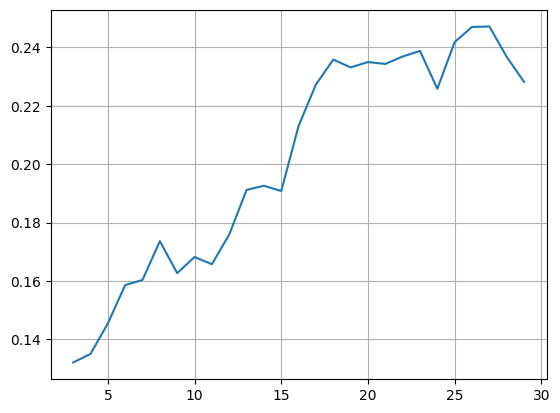

In [17]:
corrs = []
window_sizes = np.arange(3, 30, 1)

for w in window_sizes:
    last_n_avgs = df.groupby('team')[['conversions_scored']] \
                .rolling(w, closed='left') \
                .mean() \
                .reset_index().rename(columns={"level_1":"row_index",
                                            "conversions_scored": f"conversions_scored_last_{w}"})
    last_n_avgs.index = last_n_avgs['row_index']
    last_n_avgs = last_n_avgs.sort_index()

    temp = pd.concat([df[['conversions_scored']], last_n_avgs[[f"conversions_scored_last_{w}"]]], 
                      axis=1).dropna()
    
    corr_ = temp.corr().iloc[0].iloc[1]
    corrs.append(corr_)
    print(f"Window size: {w} - Corr: {round(corr_, 3)}")


plt.plot(window_sizes, corrs)
plt.grid(True)
plt.show()

In [18]:
conversions_scored_last_18 = get_window_average(df, 'conversions_scored', 18).sort_index()
conversions_scored_last_13 = get_window_average(df, 'conversions_scored', 13).sort_index()
conversions_scored_last_8 = get_window_average(df, 'conversions_scored', 8).sort_index()

conversions_scored_last_18.tail()

,conversions_scored_last_18
row_index,
1009,2.333333
1010,1.888889
1011,2.277778
1012,1.777778
1013,3.000000


Window size: 3 - Corr: -0.014
Window size: 4 - Corr: 0.009
Window size: 5 - Corr: 0.019
Window size: 6 - Corr: 0.046
Window size: 7 - Corr: 0.023
Window size: 8 - Corr: 0.042
Window size: 9 - Corr: 0.031
Window size: 10 - Corr: 0.025
Window size: 11 - Corr: 0.011
Window size: 12 - Corr: 0.008
Window size: 13 - Corr: 0.004
Window size: 14 - Corr: 0.001
Window size: 15 - Corr: -0.011
Window size: 16 - Corr: 0.004
Window size: 17 - Corr: 0.026
Window size: 18 - Corr: 0.063
Window size: 19 - Corr: 0.054
Window size: 20 - Corr: 0.042
Window size: 21 - Corr: 0.049
Window size: 22 - Corr: 0.051
Window size: 23 - Corr: 0.061
Window size: 24 - Corr: 0.068
Window size: 25 - Corr: 0.072
Window size: 26 - Corr: 0.073
Window size: 27 - Corr: 0.067
Window size: 28 - Corr: 0.061
Window size: 29 - Corr: 0.069


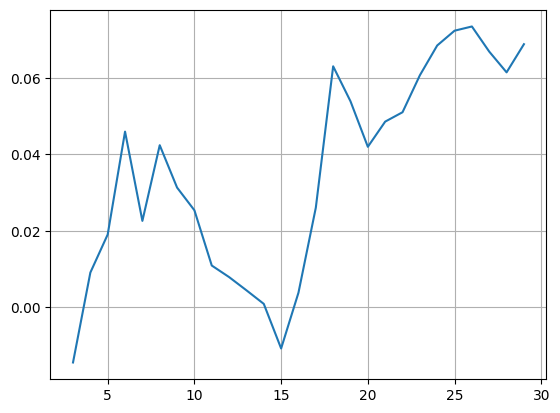

In [19]:
corrs = []
window_sizes = np.arange(3, 30, 1)

for w in window_sizes:
    last_n_avgs = df.groupby('team')[['pen_tries_scored']] \
                .rolling(w, closed='left') \
                .mean() \
                .reset_index().rename(columns={"level_1":"row_index",
                                            "pen_tries_scored": f"pen_tries_scored_last_{w}"})
    last_n_avgs.index = last_n_avgs['row_index']
    last_n_avgs = last_n_avgs.sort_index()

    temp = pd.concat([df[['team_score']], last_n_avgs[[f"pen_tries_scored_last_{w}"]]], 
                      axis=1).dropna()
    
    corr_ = temp.corr().iloc[0].iloc[1]
    corrs.append(corr_)
    print(f"Window size: {w} - Corr: {round(corr_, 3)}")


plt.plot(window_sizes, corrs)
plt.grid(True)
plt.show()

In [20]:
pen_tries_scored_last_18 = get_window_average(df, 'pen_tries_scored', 18).sort_index()
pen_tries_scored_last_8 = get_window_average(df, 'pen_tries_scored', 8).sort_index()

pen_tries_scored_last_18.tail()

,pen_tries_scored_last_18
row_index,
1009,0.055556
1010,0.055556
1011,0.055556
1012,0.222222
1013,0.055556


# Create features for model - avg scored and conceded in window before game

In [21]:
last_n_window_avg_scored_df = pd.concat([tries_scored_last_18, tries_scored_last_13, tries_scored_last_8,
                                        pens_scored_last_18, pens_scored_last_14, pens_scored_last_8,
                                        conversions_scored_last_18, conversions_scored_last_13, conversions_scored_last_8,
                                        pen_tries_scored_last_18, pen_tries_scored_last_8], axis=1)

last_n_window_avg_scored_df.tail()

,tries_scored_last_18,tries_scored_last_13,tries_scored_last_8,pen_kicks_scored_last_18,pen_kicks_scored_last_13,pen_kicks_scored_last_8,conversions_scored_last_18,conversions_scored_last_13,conversions_scored_last_8,pen_tries_scored_last_18,pen_tries_scored_last_8
row_index,,,,,,,,,,,
1009,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
1010,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
1011,3.055556,2.923077,3.125,1.055556,1.153846,1.125,2.277778,2.153846,2.625,0.055556,0.000
1012,2.611111,2.692308,2.250,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.250
1013,3.888889,3.846154,3.500,1.611111,1.615385,2.125,3.000000,2.846154,2.500,0.055556,0.000


In [22]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_18,tries_scored_last_13,tries_scored_last_8,pen_kicks_scored_last_18,pen_kicks_scored_last_13,pen_kicks_scored_last_8,conversions_scored_last_18,conversions_scored_last_13,conversions_scored_last_8,pen_tries_scored_last_18,pen_tries_scored_last_8
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
1010,502,CARDIFF,DRAGONS,Home,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
1011,501,SHARKS,STORMERS,Home,3.055556,2.923077,3.125,1.055556,1.153846,1.125,2.277778,2.153846,2.625,0.055556,0.000
1012,505,OSPREYS,ZEBRE,Away,2.611111,2.692308,2.250,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.250


In [23]:
home_team_overall_avgs = temp.loc[temp['team_location']=='Home']
home_team_overall_avgs.columns = ['home_team_' + i + '_matches' if 'scored' in i else i for i in home_team_overall_avgs.columns]
home_team_overall_avgs.index = home_team_overall_avgs['match_per_row_index']
home_team_overall_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_last_18_matches,home_team_tries_scored_last_13_matches,home_team_tries_scored_last_8_matches,home_team_pen_kicks_scored_last_18_matches,home_team_pen_kicks_scored_last_13_matches,home_team_pen_kicks_scored_last_8_matches,home_team_conversions_scored_last_18_matches,home_team_conversions_scored_last_13_matches,home_team_conversions_scored_last_8_matches,home_team_pen_tries_scored_last_18_matches,home_team_pen_tries_scored_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
503,503,CONNACHT,BULLS,Home,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
504,504,EDINBURGH,BENETTON,Home,2.722222,3.076923,2.625,1.555556,1.307692,1.625,2.277778,2.615385,2.125,0.055556,0.000
505,505,ZEBRE,OSPREYS,Home,1.722222,1.538462,1.750,1.388889,1.461538,1.625,1.222222,0.923077,1.000,0.000000,0.000
506,506,MUNSTER,LIONS,Home,3.722222,3.692308,3.250,0.944444,0.846154,0.625,2.611111,2.461538,2.125,0.055556,0.000


In [24]:
away_team_overall_avgs = temp.loc[temp['team_location']=='Away']
away_team_overall_avgs.columns = ['away_team_' + i + '_matches' if 'scored' in i else i for i in away_team_overall_avgs.columns]
away_team_overall_avgs.index = away_team_overall_avgs['match_per_row_index']

del(temp)

away_team_overall_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_last_18_matches,away_team_tries_scored_last_13_matches,away_team_tries_scored_last_8_matches,away_team_pen_kicks_scored_last_18_matches,away_team_pen_kicks_scored_last_13_matches,away_team_pen_kicks_scored_last_8_matches,away_team_conversions_scored_last_18_matches,away_team_conversions_scored_last_13_matches,away_team_conversions_scored_last_8_matches,away_team_pen_tries_scored_last_18_matches,away_team_pen_tries_scored_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,2.111111,2.153846,2.00,1.111111,1.307692,1.250,1.611111,1.538462,1.500,0.111111,0.00
503,503,BULLS,CONNACHT,Away,3.888889,4.153846,3.25,1.666667,1.384615,1.500,2.944444,3.153846,2.625,0.055556,0.00
504,504,BENETTON,EDINBURGH,Away,3.111111,3.307692,2.75,1.333333,1.230769,1.375,2.111111,2.230769,1.875,0.000000,0.00
505,505,OSPREYS,ZEBRE,Away,2.611111,2.692308,2.25,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.25
506,506,LIONS,MUNSTER,Away,3.888889,3.846154,3.50,1.611111,1.615385,2.125,3.000000,2.846154,2.500,0.055556,0.00


In [25]:
tries_conceded_last_18 = get_window_average(df, 'tries_conceded', 18).sort_index()
tries_conceded_last_13 = get_window_average(df, 'tries_conceded', 13).sort_index()
tries_conceded_last_8 = get_window_average(df, 'tries_conceded', 8).sort_index()

pens_conceded_last_18 = get_window_average(df, 'pen_kicks_conceded', 18).sort_index()
pens_conceded_last_14 = get_window_average(df, 'pen_kicks_conceded', 13).sort_index()
pens_conceded_last_8 = get_window_average(df, 'pen_kicks_conceded', 8).sort_index()

conversions_conceded_last_18 = get_window_average(df, 'conversions_conceded', 18).sort_index()
conversions_conceded_last_13 = get_window_average(df, 'conversions_conceded', 13).sort_index()
conversions_conceded_last_8 = get_window_average(df, 'conversions_conceded', 8).sort_index()

pen_tries_conceded_last_18 = get_window_average(df, 'pen_tries_conceded', 18).sort_index()
pen_tries_conceded_last_8 = get_window_average(df, 'pen_tries_conceded', 8).sort_index()


last_n_window_avg_conceded_df = pd.concat([tries_conceded_last_18, tries_conceded_last_13, tries_conceded_last_8,
                                pens_conceded_last_18, pens_conceded_last_14, pens_conceded_last_8,
                                conversions_conceded_last_18, conversions_conceded_last_13, conversions_conceded_last_8,
                                pen_tries_conceded_last_18, pen_tries_conceded_last_8], axis=1)

last_n_window_avg_conceded_df.tail()

,tries_conceded_last_18,tries_conceded_last_13,tries_conceded_last_8,pen_kicks_conceded_last_18,pen_kicks_conceded_last_13,pen_kicks_conceded_last_8,conversions_conceded_last_18,conversions_conceded_last_13,conversions_conceded_last_8,pen_tries_conceded_last_18,pen_tries_conceded_last_8
row_index,,,,,,,,,,,
1009,3.111111,3.615385,3.375,1.166667,1.153846,1.250,2.333333,2.769231,2.750,0.000000,0.000
1010,3.277778,3.153846,3.625,1.055556,1.153846,0.625,2.333333,2.461538,2.500,0.166667,0.125
1011,3.500000,3.769231,4.250,1.111111,0.846154,0.875,2.611111,2.846154,3.000,0.055556,0.000
1012,3.333333,3.846154,3.125,1.500000,1.230769,1.750,2.277778,2.692308,1.750,0.166667,0.125
1013,2.777778,2.692308,2.625,1.000000,0.923077,0.875,1.888889,1.846154,1.875,0.111111,0.125


In [26]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_18,tries_conceded_last_13,tries_conceded_last_8,pen_kicks_conceded_last_18,pen_kicks_conceded_last_13,pen_kicks_conceded_last_8,conversions_conceded_last_18,conversions_conceded_last_13,conversions_conceded_last_8,pen_tries_conceded_last_18,pen_tries_conceded_last_8
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.111111,3.615385,3.375,1.166667,1.153846,1.250,2.333333,2.769231,2.750,0.000000,0.000
1010,502,CARDIFF,DRAGONS,Home,3.277778,3.153846,3.625,1.055556,1.153846,0.625,2.333333,2.461538,2.500,0.166667,0.125
1011,501,SHARKS,STORMERS,Home,3.500000,3.769231,4.250,1.111111,0.846154,0.875,2.611111,2.846154,3.000,0.055556,0.000
1012,505,OSPREYS,ZEBRE,Away,3.333333,3.846154,3.125,1.500000,1.230769,1.750,2.277778,2.692308,1.750,0.166667,0.125


In [27]:
home_team_overall_conceded_avgs = temp.loc[temp['team_location']=='Home']
home_team_overall_conceded_avgs.columns = ['home_team_' + i + '_matches' if 'conceded' in i else i for i in home_team_overall_conceded_avgs.columns]
home_team_overall_conceded_avgs.index = home_team_overall_conceded_avgs['match_per_row_index']
home_team_overall_conceded_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_conceded_last_18_matches,home_team_tries_conceded_last_13_matches,home_team_tries_conceded_last_8_matches,home_team_pen_kicks_conceded_last_18_matches,home_team_pen_kicks_conceded_last_13_matches,home_team_pen_kicks_conceded_last_8_matches,home_team_conversions_conceded_last_18_matches,home_team_conversions_conceded_last_13_matches,home_team_conversions_conceded_last_8_matches,home_team_pen_tries_conceded_last_18_matches,home_team_pen_tries_conceded_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.277778,3.153846,3.625,1.055556,1.153846,0.625,2.333333,2.461538,2.500,0.166667,0.125
503,503,CONNACHT,BULLS,Home,3.111111,3.615385,3.375,1.166667,1.153846,1.250,2.333333,2.769231,2.750,0.000000,0.000
504,504,EDINBURGH,BENETTON,Home,3.166667,3.461538,3.750,0.833333,0.692308,0.625,2.111111,2.307692,2.625,0.000000,0.000
505,505,ZEBRE,OSPREYS,Home,4.777778,4.692308,4.125,0.666667,0.769231,1.125,3.222222,3.153846,2.625,0.111111,0.000
506,506,MUNSTER,LIONS,Home,2.722222,2.923077,3.375,1.166667,1.076923,0.750,2.111111,2.384615,2.750,0.000000,0.000


In [28]:
away_team_overall_conceded_avgs = temp.loc[temp['team_location']=='Away']
away_team_overall_conceded_avgs.columns = ['away_team_' + i + '_matches' if 'conceded' in i else i for i in away_team_overall_conceded_avgs.columns]
away_team_overall_conceded_avgs.index = away_team_overall_conceded_avgs['match_per_row_index']

del(temp)

away_team_overall_conceded_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_conceded_last_18_matches,away_team_tries_conceded_last_13_matches,away_team_tries_conceded_last_8_matches,away_team_pen_kicks_conceded_last_18_matches,away_team_pen_kicks_conceded_last_13_matches,away_team_pen_kicks_conceded_last_8_matches,away_team_conversions_conceded_last_18_matches,away_team_conversions_conceded_last_13_matches,away_team_conversions_conceded_last_8_matches,away_team_pen_tries_conceded_last_18_matches,away_team_pen_tries_conceded_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,4.611111,4.076923,4.000,1.055556,1.230769,1.125,3.388889,2.923077,2.750,0.000000,0.000
503,503,BULLS,CONNACHT,Away,2.833333,2.769231,2.250,1.277778,1.384615,1.750,2.277778,2.230769,1.625,0.000000,0.000
504,504,BENETTON,EDINBURGH,Away,3.388889,3.461538,2.750,0.833333,0.846154,1.125,2.777778,2.769231,2.625,0.055556,0.125
505,505,OSPREYS,ZEBRE,Away,3.333333,3.846154,3.125,1.500000,1.230769,1.750,2.277778,2.692308,1.750,0.166667,0.125
506,506,LIONS,MUNSTER,Away,2.777778,2.692308,2.625,1.000000,0.923077,0.875,1.888889,1.846154,1.875,0.111111,0.125


# windowing to get avgs for just home games

In [29]:
home_games_only_df = df.loc[df['team_location']=='Home']

tries_scored_last_9_home = get_window_average(home_games_only_df, 'tries_scored', 9).sort_index()
tries_scored_last_6_home = get_window_average(home_games_only_df, 'tries_scored', 6).sort_index()

pens_scored_last_9_home = get_window_average(home_games_only_df, 'pen_kicks_scored', 9).sort_index()
pens_scored_last_6_home = get_window_average(home_games_only_df, 'pen_kicks_scored', 6).sort_index()

conversions_scored_last_9_home = get_window_average(home_games_only_df, 'conversions_scored', 9).sort_index()
conversions_scored_last_6_home = get_window_average(home_games_only_df, 'conversions_scored', 6).sort_index()

pen_tries_scored_last_9_home = get_window_average(home_games_only_df, 'pen_tries_scored', 9).sort_index()
pen_tries_scored_last_6_home = get_window_average(home_games_only_df, 'pen_tries_scored', 6).sort_index()


last_n_window_avg_scored_home_df = pd.concat([tries_scored_last_9_home, tries_scored_last_6_home,
                                            pens_scored_last_9_home, pens_scored_last_6_home,
                                            conversions_scored_last_9_home, conversions_scored_last_6_home,
                                            pen_tries_scored_last_9_home, pen_tries_scored_last_6_home], axis=1)

last_n_window_avg_scored_home_df.tail()

,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
row_index,,,,,,,,
1007,1.888889,1.666667,1.777778,1.666667,1.222222,0.833333,0.000000,0.000000
1008,3.777778,4.666667,1.666667,1.166667,2.777778,3.666667,0.000000,0.000000
1009,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
1010,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
1011,3.000000,3.166667,1.000000,1.166667,2.222222,2.333333,0.000000,0.000000


In [30]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_home_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
1010,502,CARDIFF,DRAGONS,Home,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
1011,501,SHARKS,STORMERS,Home,3.000000,3.166667,1.000000,1.166667,2.222222,2.333333,0.000000,0.000000
1012,505,OSPREYS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
home_team_scored_avgs_home_games = temp.loc[temp['team_location']=='Home']
home_team_scored_avgs_home_games.columns = ['home_team_' + i + '_home_matches' if 'scored' in i else i for i in home_team_scored_avgs_home_games.columns]
home_team_scored_avgs_home_games.index = home_team_scored_avgs_home_games['match_per_row_index']

del(temp)

home_team_scored_avgs_home_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_last_9_home_matches,home_team_tries_scored_last_6_home_matches,home_team_pen_kicks_scored_last_9_home_matches,home_team_pen_kicks_scored_last_6_home_matches,home_team_conversions_scored_last_9_home_matches,home_team_conversions_scored_last_6_home_matches,home_team_pen_tries_scored_last_9_home_matches,home_team_pen_tries_scored_last_6_home_matches
match_per_row_index,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
503,503,CONNACHT,BULLS,Home,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
504,504,EDINBURGH,BENETTON,Home,3.777778,4.666667,1.666667,1.166667,2.777778,3.666667,0.000000,0.000000
505,505,ZEBRE,OSPREYS,Home,1.888889,1.666667,1.777778,1.666667,1.222222,0.833333,0.000000,0.000000
506,506,MUNSTER,LIONS,Home,3.555556,3.833333,1.000000,1.000000,2.666667,2.833333,0.000000,0.000000


In [32]:
home_games_only_df = df.loc[df['team_location']=='Home']

tries_conceded_last_9_home = get_window_average(home_games_only_df, 'tries_conceded', 9).sort_index()
tries_conceded_last_6_home = get_window_average(home_games_only_df, 'tries_conceded', 6).sort_index()

pens_conceded_last_9_home = get_window_average(home_games_only_df, 'pen_kicks_conceded', 9).sort_index()
pens_conceded_last_6_home = get_window_average(home_games_only_df, 'pen_kicks_conceded', 6).sort_index()

conversions_conceded_last_9_home = get_window_average(home_games_only_df, 'conversions_conceded', 9).sort_index()
conversions_conceded_last_6_home = get_window_average(home_games_only_df, 'conversions_conceded', 6).sort_index()

pen_tries_conceded_last_9_home = get_window_average(home_games_only_df, 'pen_tries_conceded', 9).sort_index()
pen_tries_conceded_last_6_home = get_window_average(home_games_only_df, 'pen_tries_conceded', 6).sort_index()


last_n_window_avg_conceded_home_df = pd.concat([tries_conceded_last_9_home, tries_conceded_last_6_home,
                                            pens_conceded_last_9_home, pens_conceded_last_6_home,
                                            conversions_conceded_last_9_home, conversions_conceded_last_6_home,
                                            pen_tries_conceded_last_9_home, pen_tries_conceded_last_6_home], axis=1)

last_n_window_avg_conceded_home_df.tail()

,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
row_index,,,,,,,,
1007,3.888889,4.166667,1.111111,1.166667,2.888889,3.000000,0.111111,0.000000
1008,2.444444,2.500000,0.666667,0.666667,1.888889,1.833333,0.000000,0.000000
1009,2.555556,3.000000,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
1010,3.666667,4.000000,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
1011,3.111111,3.500000,1.000000,0.833333,2.000000,2.333333,0.111111,0.000000


In [33]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_home_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,2.555556,3.0,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
1010,502,CARDIFF,DRAGONS,Home,3.666667,4.0,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
1011,501,SHARKS,STORMERS,Home,3.111111,3.5,1.000000,0.833333,2.000000,2.333333,0.111111,0.000000
1012,505,OSPREYS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
home_team_conceded_avgs_home_games = temp.loc[temp['team_location']=='Home']
home_team_conceded_avgs_home_games.columns = ['home_team_' + i + '_home_matches' if 'conceded' in i else i for i in home_team_conceded_avgs_home_games.columns]
home_team_conceded_avgs_home_games.index = home_team_conceded_avgs_home_games['match_per_row_index']

del(temp)

home_team_conceded_avgs_home_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_conceded_last_9_home_matches,home_team_tries_conceded_last_6_home_matches,home_team_pen_kicks_conceded_last_9_home_matches,home_team_pen_kicks_conceded_last_6_home_matches,home_team_conversions_conceded_last_9_home_matches,home_team_conversions_conceded_last_6_home_matches,home_team_pen_tries_conceded_last_9_home_matches,home_team_pen_tries_conceded_last_6_home_matches
match_per_row_index,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.666667,4.000000,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
503,503,CONNACHT,BULLS,Home,2.555556,3.000000,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
504,504,EDINBURGH,BENETTON,Home,2.444444,2.500000,0.666667,0.666667,1.888889,1.833333,0.000000,0.000000
505,505,ZEBRE,OSPREYS,Home,3.888889,4.166667,1.111111,1.166667,2.888889,3.000000,0.111111,0.000000
506,506,MUNSTER,LIONS,Home,2.111111,2.166667,0.777778,0.333333,1.666667,1.833333,0.000000,0.000000


# windowing to get avgs for just away games

In [35]:
away_games_only_df = df.loc[df['team_location']=='Away']

tries_scored_last_9_away = get_window_average(away_games_only_df, 'tries_scored', 9).sort_index()
tries_scored_last_6_away = get_window_average(away_games_only_df, 'tries_scored', 6).sort_index()

pens_scored_last_9_away = get_window_average(away_games_only_df, 'pen_kicks_scored', 9).sort_index()
pens_scored_last_6_away = get_window_average(away_games_only_df, 'pen_kicks_scored', 6).sort_index()

conversions_scored_last_9_away = get_window_average(away_games_only_df, 'conversions_scored', 9).sort_index()
conversions_scored_last_6_away = get_window_average(away_games_only_df, 'conversions_scored', 6).sort_index()

pen_tries_scored_last_9_away = get_window_average(away_games_only_df, 'pen_tries_scored', 9).sort_index()
pen_tries_scored_last_6_away = get_window_average(away_games_only_df, 'pen_tries_scored', 6).sort_index()


last_n_window_avg_scored_away_df = pd.concat([tries_scored_last_9_away, tries_scored_last_6_away,
                                                pens_scored_last_9_away, pens_scored_last_6_away,
                                                conversions_scored_last_9_away, conversions_scored_last_6_away,
                                                pen_tries_scored_last_9_away, pen_tries_scored_last_6_away], axis=1)

last_n_window_avg_scored_away_df.tail()

,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
row_index,,,,,,,,
1003,1.777778,1.666667,0.666667,0.833333,1.444444,1.166667,0.222222,0.166667
1004,3.111111,3.500000,1.333333,1.166667,2.444444,2.666667,0.000000,0.000000
1005,3.000000,3.000000,1.333333,1.166667,2.000000,2.333333,0.000000,0.000000
1012,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333
1013,2.222222,2.333333,1.666667,1.666667,1.777778,1.833333,0.111111,0.000000


In [36]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_away_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,502,CARDIFF,DRAGONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,501,SHARKS,STORMERS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,505,OSPREYS,ZEBRE,Away,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333


In [37]:
away_team_scored_avgs_away_games = temp.loc[temp['team_location']=='Away']
away_team_scored_avgs_away_games.columns = ['away_team_' + i + '_away_matches' if 'scored' in i else i for i in away_team_scored_avgs_away_games.columns]
away_team_scored_avgs_away_games.index = away_team_scored_avgs_away_games['match_per_row_index']

del(temp)

away_team_scored_avgs_away_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_last_9_away_matches,away_team_tries_scored_last_6_away_matches,away_team_pen_kicks_scored_last_9_away_matches,away_team_pen_kicks_scored_last_6_away_matches,away_team_conversions_scored_last_9_away_matches,away_team_conversions_scored_last_6_away_matches,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches
match_per_row_index,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,1.777778,1.666667,0.666667,0.833333,1.444444,1.166667,0.222222,0.166667
503,503,BULLS,CONNACHT,Away,3.000000,3.000000,1.333333,1.166667,2.000000,2.333333,0.000000,0.000000
504,504,BENETTON,EDINBURGH,Away,3.111111,3.500000,1.333333,1.166667,2.444444,2.666667,0.000000,0.000000
505,505,OSPREYS,ZEBRE,Away,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333
506,506,LIONS,MUNSTER,Away,2.222222,2.333333,1.666667,1.666667,1.777778,1.833333,0.111111,0.000000


In [38]:
away_games_only_df = df.loc[df['team_location']=='Away']

tries_conceded_last_9_away = get_window_average(away_games_only_df, 'tries_conceded', 9).sort_index()
tries_conceded_last_6_away = get_window_average(away_games_only_df, 'tries_conceded', 6).sort_index()

pens_conceded_last_9_away = get_window_average(away_games_only_df, 'pen_kicks_conceded', 9).sort_index()
pens_conceded_last_6_away = get_window_average(away_games_only_df, 'pen_kicks_conceded', 6).sort_index()

conversions_conceded_last_9_away = get_window_average(away_games_only_df, 'conversions_conceded', 9).sort_index()
conversions_conceded_last_6_away = get_window_average(away_games_only_df, 'conversions_conceded', 6).sort_index()

pen_tries_conceded_last_9_away = get_window_average(away_games_only_df, 'pen_tries_conceded', 9).sort_index()
pen_tries_conceded_last_6_away = get_window_average(away_games_only_df, 'pen_tries_conceded', 6).sort_index()


last_n_window_avg_conceded_away_df = pd.concat([tries_conceded_last_9_away, tries_conceded_last_6_away,
                                                pens_conceded_last_9_away, pens_conceded_last_6_away,
                                                conversions_conceded_last_9_away, conversions_conceded_last_6_away,
                                                pen_tries_conceded_last_9_away, pen_tries_conceded_last_6_away], axis=1)

last_n_window_avg_conceded_away_df.tail()

,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
row_index,,,,,,,,
1003,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
1004,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
1005,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
1012,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667
1013,2.777778,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667


In [55]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_away_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,502,CARDIFF,DRAGONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,501,SHARKS,STORMERS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,505,OSPREYS,ZEBRE,Away,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667


In [56]:
away_team_conceded_avgs_away_games = temp.loc[temp['team_location']=='Away']
away_team_conceded_avgs_away_games.columns = ['away_team_' + i + '_away_matches' if 'conceded' in i else i for i in away_team_conceded_avgs_away_games.columns]
away_team_conceded_avgs_away_games.index = away_team_conceded_avgs_away_games['match_per_row_index']

del(temp)

away_team_conceded_avgs_away_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
match_per_row_index,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
503,503,BULLS,CONNACHT,Away,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
504,504,BENETTON,EDINBURGH,Away,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
505,505,OSPREYS,ZEBRE,Away,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667
506,506,LIONS,MUNSTER,Away,2.777778,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667


In [57]:
# Join all features together

In [69]:
ml_df = pd.concat([raw_df[['match_date_dt', 'home_team', 'away_team', 'outcome',
                
                             'home_forwards_average_age', 'home_backs_average_age',
                            'away_forwards_average_age', 'away_backs_average_age',
                            'home_tallest_player', 'home_pack_weight_kg',
                            'away_tallest_player', 'away_pack_weight_kg'
                           ]],
                    home_team_overall_avgs,
                    away_team_overall_avgs,
                
                    home_team_overall_conceded_avgs,
                    away_team_overall_conceded_avgs,
                    
                    home_team_scored_avgs_home_games,
                    home_team_conceded_avgs_home_games,
                    
                    away_team_scored_avgs_away_games,
                    away_team_conceded_avgs_away_games
                    
                    # home_team_overall_avgs[['home_team_tries_scored_last_18_matches']],
                    # away_team_overall_avgs[['away_team_tries_scored_last_18_matches']],
                    
                    # home_team_overall_conceded_avgs[['home_team_tries_conceded_last_18_matches']],
                    # away_team_overall_conceded_avgs[['away_team_tries_conceded_last_18_matches']],
                
                    # home_team_scored_avgs_home_games[['home_team_tries_scored_last_9_home_matches']],
                    # home_team_conceded_avgs_home_games[['home_team_tries_conceded_last_9_home_matches']],
                
                    # away_team_scored_avgs_away_games[['away_team_tries_scored_last_9_away_matches']],
                    # away_team_conceded_avgs_away_games[['away_team_tries_conceded_last_9_away_matches']]
                    
                    ],
                      axis=1
                     ).drop(columns=['match_per_row_index', 'team', 'opponents', 'team_location']).dropna()

ml_df

,match_date_dt,home_team,away_team,outcome,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,home_pack_weight_kg,...,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
144,2022-06-03,ULSTER,MUNSTER,1,29,26,27,28,198,920,...,0.000000,0.000000,1.666667,2.166667,2.666667,2.500000,1.444444,1.833333,0.111111,0.166667
145,2022-06-04,BULLS,SHARKS,1,26,25,28,26,203,924,...,0.000000,0.000000,3.222222,2.833333,1.333333,1.333333,2.333333,2.000000,0.000000,0.000000
146,2022-06-04,LEINSTER,GLASGOW,1,25,28,29,27,201,912,...,0.222222,0.166667,3.222222,3.666667,1.666667,1.666667,2.444444,3.000000,0.111111,0.000000
147,2022-06-04,STORMERS,EDINBURGH,1,27,26,29,27,200,927,...,0.000000,0.000000,2.444444,2.666667,1.333333,1.500000,2.000000,2.166667,0.000000,0.000000
148,2022-06-10,LEINSTER,BULLS,-1,26,29,26,26,201,910,...,0.000000,0.000000,2.222222,1.666667,2.333333,2.500000,1.777778,1.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2024-11-30,CARDIFF,DRAGONS,0,28,27,27,26,201,911,...,0.222222,0.166667,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
503,2024-11-30,CONNACHT,BULLS,0,29,26,27,27,201,901,...,0.000000,0.000000,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
504,2024-11-30,EDINBURGH,BENETTON,0,28,26,28,27,200,931,...,0.000000,0.000000,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
505,2024-11-30,ZEBRE,OSPREYS,0,25,26,27,25,202,890,...,0.222222,0.333333,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667


In [70]:
ml_df.columns.tolist()

['match_date_dt',
 'home_team',
 'away_team',
 'outcome',
 'home_forwards_average_age',
 'home_backs_average_age',
 'away_forwards_average_age',
 'away_backs_average_age',
 'home_tallest_player',
 'home_pack_weight_kg',
 'away_tallest_player',
 'away_pack_weight_kg',
 'home_team_tries_scored_last_18_matches',
 'home_team_tries_scored_last_13_matches',
 'home_team_tries_scored_last_8_matches',
 'home_team_pen_kicks_scored_last_18_matches',
 'home_team_pen_kicks_scored_last_13_matches',
 'home_team_pen_kicks_scored_last_8_matches',
 'home_team_conversions_scored_last_18_matches',
 'home_team_conversions_scored_last_13_matches',
 'home_team_conversions_scored_last_8_matches',
 'home_team_pen_tries_scored_last_18_matches',
 'home_team_pen_tries_scored_last_8_matches',
 'away_team_tries_scored_last_18_matches',
 'away_team_tries_scored_last_13_matches',
 'away_team_tries_scored_last_8_matches',
 'away_team_pen_kicks_scored_last_18_matches',
 'away_team_pen_kicks_scored_last_13_matches',
 'a

In [72]:
ml_df.tail(10)

,match_date_dt,home_team,away_team,outcome,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,home_pack_weight_kg,...,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
497,2024-10-26,CONNACHT,DRAGONS,1,27,26,26,26,201,894,...,0.222222,0.166667,6.444444,5.500000,0.666667,0.333333,4.555556,3.833333,0.000000,0.000000
498,2024-10-26,CARDIFF,ULSTER,1,27,27,27,26,201,915,...,0.000000,0.000000,3.555556,4.166667,1.333333,1.333333,2.777778,3.166667,0.000000,0.000000
499,2024-11-29,GLASGOW,SCARLETS,1,26,27,29,25,207,915,...,0.000000,0.000000,3.666667,3.166667,1.111111,1.000000,2.777778,2.000000,0.111111,0.166667
500,2024-11-29,ULSTER,LEINSTER,-1,26,26,27,25,199,899,...,0.111111,0.166667,3.111111,3.000000,1.222222,1.333333,2.000000,2.000000,0.000000,0.000000
501,2024-11-30,SHARKS,STORMERS,0,29,26,30,27,203,909,...,0.000000,0.000000,3.111111,2.833333,1.444444,1.333333,2.666667,2.166667,0.111111,0.166667
502,2024-11-30,CARDIFF,DRAGONS,0,28,27,27,26,201,911,...,0.222222,0.166667,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
503,2024-11-30,CONNACHT,BULLS,0,29,26,27,27,201,901,...,0.000000,0.000000,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
504,2024-11-30,EDINBURGH,BENETTON,0,28,26,28,27,200,931,...,0.000000,0.000000,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
505,2024-11-30,ZEBRE,OSPREYS,0,25,26,27,25,202,890,...,0.222222,0.333333,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667
506,2024-11-30,MUNSTER,LIONS,0,27,27,26,26,201,887,...,0.111111,0.000000,2.777778,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667


In [75]:
X = ml_df.loc[ml_df['match_date_dt'] < '2024-11-30']
X_holdout = ml_df.loc[ml_df['match_date_dt'] == '2024-11-30']

to_drop = ['match_date_dt', 'home_team', 'away_team', ]
X.drop(columns=to_drop, inplace=True)
X_holdout.drop(columns=['match_date_dt'], inplace=True)

y = X.pop('outcome')
y_holdout = X_holdout.pop('outcome')

X.shape, X_holdout.shape, y.shape, y_holdout.shape

/var/folders/xr/_sn2jn9s3xd13fp9ljzys7tm0000gn/T/ipykernel_11022/4010249641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=to_drop, inplace=True)
/var/folders/xr/_sn2jn9s3xd13fp9ljzys7tm0000gn/T/ipykernel_11022/4010249641.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_holdout.drop(columns=['match_date_dt'], inplace=True)


((357, 84), (6, 86), (357,), (6,))

In [77]:
X.tail()

,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,home_pack_weight_kg,away_tallest_player,away_pack_weight_kg,home_team_tries_scored_last_18_matches,home_team_tries_scored_last_13_matches,...,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
496,27,25,27,25,207,911,202,917,4.444444,4.615385,...,0.111111,0.000000,2.666667,2.833333,1.444444,1.333333,2.222222,2.333333,0.000000,0.000000
497,27,26,26,26,201,894,198,918,3.055556,3.384615,...,0.222222,0.166667,6.444444,5.500000,0.666667,0.333333,4.555556,3.833333,0.000000,0.000000
498,27,27,27,26,201,915,201,916,3.000000,2.692308,...,0.000000,0.000000,3.555556,4.166667,1.333333,1.333333,2.777778,3.166667,0.000000,0.000000
499,26,27,29,25,207,915,201,909,4.277778,4.384615,...,0.000000,0.000000,3.666667,3.166667,1.111111,1.000000,2.777778,2.000000,0.111111,0.166667
500,26,26,27,25,199,899,200,900,3.222222,3.230769,...,0.111111,0.166667,3.111111,3.000000,1.222222,1.333333,2.000000,2.000000,0.000000,0.000000


In [79]:
y.value_counts()

outcome
 1    226
-1    124
 0      7
Name: count, dtype: int64

In [87]:
y_test.value_counts()

outcome
 1    46
-1    25
 0     1
Name: count, dtype: int64

In [86]:
y_train.value_counts()

outcome
 1    180
-1     99
 0      6
Name: count, dtype: int64

In [91]:
folds = 5

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/folds), random_state=11, stratify=y)

scalar = StandardScaler()
clf = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

cv = KFold(n_splits=(folds - 1))

scores = cross_val_score(pipeline,
                         X, 
                         y, 
                         scoring='roc_auc_ovr', 
                         cv = cv)



scores.mean()

0.6500719071726259

In [92]:
folds = 5

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/folds), random_state=11, stratify=y)

scalar = StandardScaler()
log = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

cv = KFold(n_splits=(folds - 1))

parameters = {
    'C': np.arange(0.1, 1, 0.05)
}
clf = GridSearchCV(log, parameters)
clf.fit(X, y)

sorted(clf.cv_results_.keys())



NameError: name 'GridSearchCV' is not defined

In [ ]:
scalar = StandardScaler()
clf = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

fitted_pipeline = pipeline.fit(X_train, y_train)

fitted_pipeline.predict(X_test)

In [ ]:
X_test

In [ ]:
roc_auc_score(y_test, fitted_pipeline.predict_proba(X_test)[:, 1])

In [ ]:
ml_df

In [ ]:
X_test_indices = X_test.index
X_test_indices

In [ ]:
results_df = ml_df.loc[X_test_indices]
results_df['preds'] = fitted_pipeline.predict(X_test)
results_df['prob_1'] = fitted_pipeline.predict_proba(X_test)[:, 1]

results_df = results_df[['match_date_dt', 'team', 'opponents', 'team_location', 'outcome', 'preds', 'prob_1']]
results_df

In [ ]:
results_df.sort_values(by=['outcome', 'preds']).iloc[30:50]

In [ ]:
results_df[['outcome', 'preds']].value_counts().sort_index()

In [ ]:
pipeline['estimator'].coef_

In [ ]:
X_test.columns

In [ ]:
pd.DataFrame({'coef_': pipeline['estimator'].coef_[0],
             'col': X_test.columns}).sort_values('coef_', ascending=False)

In [ ]:
scalar = StandardScaler()
clf = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

fitted_pipeline = pipeline.fit(X, y)



In [ ]:
X_future

In [ ]:
fitted_pipeline.predict(X_future.drop(columns=['team', 'opponents', 'pred']))

In [ ]:
pred = fitted_pipeline.predict(X_future.drop(columns=['team', 'opponents', 'pred', 'prob']))
X_future['prob_1'] = fitted_pipeline.predict_proba(X_future.drop(columns=['team', 'opponents', 'pred', 'prob']))[:, 1]
X_future['pred'] = pred


In [ ]:
X_future[['team', 'opponents', 'team_location', 'pred', 'prob_1']].sort_values(by='prob_1')

In [ ]:
# pass a date to function
# use date to calculate the team attack and defense strengths up to but not including that date
# assumes match data is already read it

def get_team_strengths(team_per_row_matches, # match level data to use
                      end_date, # last date to consider 
                      use_all_seasons=True
                      ):
    # match data to use
    df = team_per_row_matches.loc[team_per_row_matches['Match Date'] < end_date]
    df = df.sort_values(by=['Match Date', 'Team Location'], ascending=[True, False])
    df = df.reset_index(drop=True)
    
    # average tries scored home and away
    home_avg_tries_scored = df.groupby('Team Location')['Tries Scored'].mean()['Home Team']
    away_avg_tries_scored = df.groupby('Team Location')['Tries Scored'].mean()['Away Team']
    
    # average tries conceded home and away
    home_avg_tries_conceded = df.groupby('Team Location')['Tries Conceded'].mean()['Home Team']
    away_avg_tries_conceded = df.groupby('Team Location')['Tries Conceded'].mean()['Away Team']
    

    # we need to recalculate our tries scored averages up until the 5th round of 23/24
    train_tries_scored_by_team = df.groupby(["Team", "Team Location"])['Tries Scored'].mean() \
                                    .reset_index().sort_values(by=['Team', 'Team Location'], ascending=[True, False]) \
                                    .pivot(index = ['Team'], columns='Team Location', values='Tries Scored').reset_index().rename_axis(None, axis=1)
    
    train_tries_scored_by_team.rename(columns={"Home Team": "Average Tries Scored Home",
                                                      "Away Team": "Average Tries Scored Away"}, inplace=True)


    # we need to recalculate our tries conceded averages up until the 5th round of 23/24
    train_tries_conceded_by_team = df.groupby(["Team", "Team Location"])['Tries Conceded'].mean() \
                                        .reset_index().sort_values(by=['Team', 'Team Location'], ascending=[True, False]) \
                                        .pivot(index = ['Team'], columns='Team Location', values='Tries Conceded').reset_index().rename_axis(None, axis=1)

    train_tries_conceded_by_team.rename(columns={"Home Team": "Average Tries Conceded Home",
                                                 "Away Team": "Average Tries Conceded Away"}, inplace=True)

    team_ratings = pd.merge(train_tries_scored_by_team, 
                            train_tries_conceded_by_team)

    # calculate team strengths from averages
    team_ratings['Attack Strength Away'] = team_ratings['Average Tries Scored Away'] / away_avg_tries_scored
    team_ratings['Attack Strength Home'] = team_ratings['Average Tries Scored Home'] / home_avg_tries_scored
    
    team_ratings['Defence Strength Away'] = team_ratings['Average Tries Conceded Away'] / away_avg_tries_conceded
    team_ratings['Defence Strength Home'] = team_ratings['Average Tries Conceded Home'] / home_avg_tries_conceded


    return team_ratings

# filter out any future fixtures, only keep historical results
end_day_filter = "2024-11-28"

team_ratings = get_team_strengths(team_per_row_matches=team_per_row_df,
                                   end_date = end_day_filter)

team_ratings

In [ ]:
fixtures = team_per_row_df.loc[(team_per_row_df['Match Date'] > "2024-11-28") &
                            (team_per_row_df['Match Date'] < "2024-12-02")][['Team', 'Opponents']].values.tolist()
fixtures

# Conversion rate

In [ ]:
common_features = ['pkey', 'match_date_', 'Home team', 'Away team']

# home data
temp1 = raw_df[common_features+['home_n_tries', 'home_n_conversions', 'pen_try_minutes_home']].copy()
temp1['Team Location'] = "Home Team"
temp1.rename(columns={"Home team": "Team",
                    "Away team": "Opponents",
                    "home_n_tries": "Tries Scored",
                     "home_n_conversions": "Conversions Scored",
                     "pen_try_minutes_home": "Pen Tries Scored"},
                    inplace=True)

# away data
temp2 = raw_df[common_features + ['away_n_tries', 'away_n_conversions', 'pen_try_minutes_away']].copy()
temp2['Team Location'] = "Away Team"
temp2.rename(columns={"Away team": "Team",
                    "Home team": "Opponents",
                    "away_n_tries": "Tries Scored",
                     "away_n_conversions": "Conversions Scored",
                     "pen_try_minutes_away": "Pen Tries Scored"},
                    inplace=True)

# concat dfs together
conversions_df = pd.concat([temp1, temp2])
conversions_df.reset_index(inplace=True, drop=True)

conversions_df.rename(columns={"match_date_": "Match Date",
                    "pkey": "Primary Key"},
                    inplace=True)

conversions_df['Match Date'] = pd.to_datetime(team_per_row_df['Match Date'])

del(temp1)
del(temp2)

# conversions_df['len_p_tries'] = [len(i) if type(i)==str else 0 for i in conversions_df['Pen Tries Scored']]
conversions_df['p_tries'] = [len(re.findall(r'[\d]+', i)
                                ) if type(i)==str else 0 for i in conversions_df['Pen Tries Scored']]

conversions_df['non_pen_tries_scored'] = conversions_df['Tries Scored'] - conversions_df['p_tries']

conversions_df.sort_values(by='p_tries').tail(5)

In [ ]:
conversion_rate_df = conversions_df.groupby('Team')[['non_pen_tries_scored', 'Conversions Scored']].sum().reset_index()

conversion_rate_df['conversion_rate'] = conversion_rate_df['Conversions Scored'] / conversion_rate_df['non_pen_tries_scored']

conversion_rate_df